In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
import numpy as np
import gc
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
x_train = joblib.load('data/x_train.pkl')
x_test = joblib.load('data/x_test.pkl')
y_train = joblib.load('data/y_train.pkl')
y_test = joblib.load('data/y_test.pkl')

## XGBoost
---

XGBoost is tested first due to its good performance on tabular datasets containing categorical features.
Since the goal is to predict probability of late returns, we can use the 'predict_proba' method for prediction.

In [3]:
# XGBoost doesn't support these symbols in column names
x_train.columns = x_train.columns.str.replace(r'[\[\]<]', '_', regex=True)
x_test.columns = x_test.columns.str.replace(r'[\[\]<]', '_', regex=True)

Parameter selection is done using grid search with cross-validation.
Not all parameters will be tested due to resource constraints.

Early stopping will not be used since the number of samples in our dataset is small.

In [4]:
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees (estimators)
    'max_depth': [3, 5, 7],                 # Maximum depth of trees
    'learning_rate': [0.01, 0.1],           # Step size
    'subsample': [0.5, 0.7, 1.0],           # Fraction of samples to use for each tree
    'colsample_bytree': [0.5, 0.7, 1.0],    # Fraction of features to use for each tree
    'scale_pos_weight': [1, 2, 5]           # Controls the balance of positive and negative weights
}

clf = xgb.XGBClassifier()

'balanced_accuracy' is used as a metric of choice when comparing estimators, as the target is imbalanced.

In [6]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           scoring='balanced_accuracy', cv=5, verbose=1, n_jobs=-1)

In [7]:
gc.collect()
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


c:\Users\Pepi\Documents\intrvju\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [1, 2, 5],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='balanced_accuracy', verbose=1)

In [11]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 5, 'subsample': 1.0}
Best score: 0.6980


acc: 0.899
balanced acc: 0.662
f1: 0.341
roc auc: 0.785


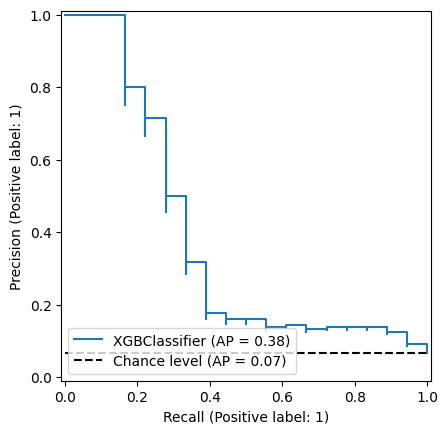

In [12]:
best_clf = grid_search.best_estimator_

print(f"acc: {accuracy_score(y_test, best_clf.predict(x_test)):.3f}")
print(f"balanced acc: {balanced_accuracy_score(y_test, best_clf.predict(x_test)):.3f}")
print(f"f1: {f1_score(y_test, best_clf.predict(x_test)):.3f}")
print(f"roc auc: {roc_auc_score(y_test, best_clf.predict_proba(x_test)[:, 1]):.3f}")
PrecisionRecallDisplay.from_estimator(
    best_clf, x_test, y_test, plot_chance_level=True
)

Feature importances from model:

In [13]:
ind = np.argsort(-best_clf.feature_importances_)
for i in range(len(x_train.columns)):
    if (best_clf.feature_importances_[ind][i]>0.01):
        print(f"{x_train.columns[ind][i]}: {best_clf.feature_importances_[ind][i]:.3f}")
    

pages: 0.109
city_portland: 0.065
zipcode: 0.054
city_beaverton: 0.043
state_washington: 0.038
price: 0.034
categories__'Agriculture'_: 0.031
city_oregon city: 0.030
city_libraries_: 0.030
city_vancouver: 0.030
city_libraries_portland: 0.030
occupation_others: 0.029
occupation_business & finance: 0.027
categories__'Advertising'_: 0.026
categories__"Mechanics' institutes"_: 0.025
education_graduate degree: 0.025
education_high school: 0.025
region_: 0.025
city_west linn: 0.023
occupation_blue collar: 0.023
education_college: 0.022
occupation_tech: 0.022
num_close_transport: 0.022
book_age: 0.022
categories__'Fire engines'_: 0.020
closest_transport: 0.020
categories__'Historical Card'_: 0.018
categories__'Social Science'_: 0.018
categories__'Nature'_: 0.017
categories__'Mechanics, Applied'_: 0.017
categories__'Transportation'_: 0.015
postal_code: 0.015
categories__'Technology & Engineering'_: 0.012


As we saw during analysis, the most important feature is the lenght of the book.

## Random Forest
---

In [14]:
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [3, 5],             # Maximum depth of trees
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split an internal node
    'min_samples_leaf': [10, 20, 50],            # Minimum samples required to be at a leaf node
    'bootstrap': [True],               # Whether bootstrap samples are used when building trees
    'class_weight': ['balanced']           # Controls the balance of positive and negative weights
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           scoring='balanced_accuracy', cv=5, verbose=1, n_jobs=-1)

In [15]:
gc.collect()

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\Pepi\Documents\intrvju\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         'max_depth': [3, 5], 'min_samples_leaf': [10, 20, 50],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='balanced_accuracy', verbose=1)

In [16]:
best_clf = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.7512


acc: 0.764
balanced acc: 0.667
f1: 0.241
roc auc: 0.771


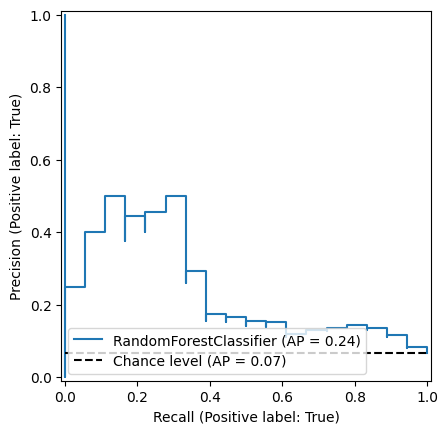

In [17]:
best_clf = grid_search.best_estimator_

print(f"acc: {accuracy_score(y_test, best_clf.predict(x_test)):.3f}")
print(f"balanced acc: {balanced_accuracy_score(y_test, best_clf.predict(x_test)):.3f}")
print(f"f1: {f1_score(y_test, best_clf.predict(x_test)):.3f}")
print(f"roc auc: {roc_auc_score(y_test, best_clf.predict_proba(x_test)[:, 1]):.3f}")
PrecisionRecallDisplay.from_estimator(
    best_clf, x_test, y_test, plot_chance_level=True
)

In [18]:
ind = np.argsort(-best_clf.feature_importances_)
for i in range(len(x_train.columns)):
    if (best_clf.feature_importances_[ind][i]>0.001):
        print(f"{x_train.columns[ind][i]}: {best_clf.feature_importances_[ind][i]:.3f}")

pages: 0.262
zipcode: 0.171
price: 0.132
city_portland: 0.112
book_age: 0.071
num_close_transport: 0.044
education_high school: 0.028
occupation_business & finance: 0.022
closest_transport: 0.022
postal_code: 0.021
education_college: 0.021
categories__'Advertising'_: 0.011
categories__'Science'_: 0.009
occupation_others: 0.008
occupation_tech: 0.008
occupation_sales: 0.007
region_: 0.007
education_graduate degree: 0.007
education_others: 0.006
categories__'Business & Economics'_: 0.006
occupation_education & health: 0.006
occupation_blue collar: 0.005
city_libraries_portland: 0.004
city_libraries_: 0.003
state_oregon: 0.003
region_or: 0.003


## SVM
---

For SVM, data needs to be standardized before fitting the model.

In [19]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.fillna(0))
x_test_scaled = scaler.transform(x_test.fillna(0))

In [20]:
svm = SVC(probability=True)

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'kernel': ['linear', 'rbf'],          # Kernel type ('linear' or 'rbf')
    'gamma': ['scale', 'auto', 0.1, 1],   # Kernel coefficient for 'rbf'
    'class_weight': ['balanced']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           scoring='balanced_accuracy', cv=5, verbose=1, n_jobs=-1)

In [21]:
gc.collect()
grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'class_weight': ['balanced'],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='balanced_accuracy', verbose=1)

In [22]:
best_clf = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best score: 0.6465


acc: 0.730
balanced acc: 0.623
f1: 0.200
roc auc: 0.667


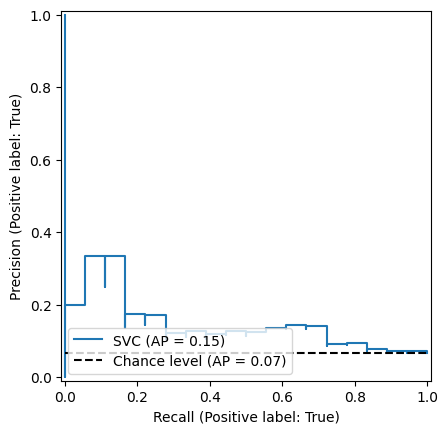

In [23]:
print(f"acc: {accuracy_score(y_test, best_clf.predict(x_test_scaled)):.3f}")
print(f"balanced acc: {balanced_accuracy_score(y_test, best_clf.predict(x_test_scaled)):.3f}")
print(f"f1: {f1_score(y_test, best_clf.predict(x_test_scaled)):.3f}")
print(f"roc auc: {roc_auc_score(y_test, best_clf.predict_proba(x_test_scaled)[:, 1]):.3f}")
PrecisionRecallDisplay.from_estimator(
    best_clf, x_test_scaled, y_test, plot_chance_level=True
)